In [110]:
import numpy as np
import random
from IPython.display import Image, display 
from graphviz import Digraph

# Define constants, variables, and operators
constant_range = np.linspace(0.5, 10, num=40)
CONSTANTS = list(constant_range)

def safe_divide(a, b):
    return np.divide(a, b, where=b != 0, out=np.full_like(a, np.nan)) # Safe divide for b != 0, else nan. With NaN, you'll know exactly where and why a result is invalid. With 0, you'll have valid numbers for calculations, but the invalid results may not be easy to track.

def safe_sqrt(a):
    return np.sqrt(a, where=a >= 0, out=np.full_like(a, np.nan)) # Safe sqrt for non-negative a, else nan. 

def safe_log(a):
    return np.log(a, where=a > 0, out=np.full_like(a, -np.inf)) # Safe log for positive a, else -inf

UNARY_OPERATORS = {
    'sin': np.sin,
    'cos': np.cos,
    'tan': np.tan,
    'sqrt': safe_sqrt,
    'log': safe_log,
    'exp': np.exp,    
    'square': np.square,
}   

BINARY_OPERATORS = {
    'add': np.add,
    'sub': np.subtract,
    'mul': np.multiply,
    'div': safe_divide,
    'pow': np.power,
}

Node class

In [111]:
class Node:
    def __init__(self, value, is_operator=False):
        """
        Initialize a Node.
        
        :param value: The value of the node (operator, constant, or variable name).
        :param is_operator: True if the node represents an operator, otherwise False.
        """
        self.value = value
        self.is_operator = is_operator
        self.left = None
        self.right = None

    def evaluate(self, variables):
        """
        Evaluate the subtree rooted at this node.
        
        :param variables: A dictionary mapping variable names to their values.
        :return: The result of evaluating the subtree.
        """
        # Check for None values to avoid errors
        if self is None:
            return 0

        if self.is_operator:
            # Unary operator (e.g., sin, log, etc.)
            if self.value in list(UNARY_OPERATORS.keys()):    
                if self.left is None:
                    raise ValueError(f"Missing left child for operator {self.value}")
                left_value = self.left.evaluate(variables)
                return UNARY_OPERATORS[self.value](left_value)
            
            # Binary operator (e.g., add, sub, mul, div, etc.)
            elif self.value in list(BINARY_OPERATORS.keys()):
                if self.left is None or self.right is None:
                    raise ValueError(f"Missing children for operator {self.value}")
                left_value = self.left.evaluate(variables)
                right_value = self.right.evaluate(variables)
                return BINARY_OPERATORS[self.value](left_value, right_value)
        
        elif self.value in variables:
            # Variable node (e.g., x0, x1, etc.)
            return variables[self.value]
        
        # Constant node (just return the constant value)
        return self.value

Individual class

In [112]:
class Individual:
    def __init__(self, root, file_path):
        """
        Initialize an Individual (a tree).
        
        :param root: The root node of the tree.
        """
        self.root = root
        self.fitness_value = None
        
        if file_path:
            self.fitness_value = self.fitness(file_path)

    def evaluate(self, variables):
        """
        Evaluate the tree.
        
        :param variables: A dictionary mapping variable names to their values.
        :return: The result of evaluating the tree.
        """
        return self.root.evaluate(variables)
    
    def tree_size(self):
        """
        Return the number of nodes in the tree.
        """
        def count_nodes(node):
            if node is None:
                return 0
            return 1 + count_nodes(node.left) + count_nodes(node.right)
        
        return count_nodes(self.root)

    def fitness(self, file_path):
        """
        Calculate the fitness of the individual using Mean Squared Error (MSE).
        
        :param file_path: Path to the .npz file containing 'x' and 'y'.
        :return: The MSE between the predicted and actual y values.
        """
        # Load the data
        data = np.load(file_path)
        x = data['x']
        y = data['y']

        # Initialize variables for prediction
        num_features = x.shape[0]
        variables = {f'x{i}': None for i in range(num_features)}

        # Compute predictions
        y_pred = []
        for i in range(x.shape[1]):  # Iterate over each column
            for j in range(num_features):  # Set variable values for this row
                variables[f'x{j}'] = x[j, i]
            y_pred.append(self.evaluate(variables))
        y_pred = np.array(y_pred)

        # Calculate MSE
        mse = np.mean((y - y_pred) ** 2)
        return mse
    
    #variant of fitness involving complexity penalty
    def fitness_with_complexity(self, file_path, complexity_penalty=0.01):
        data = np.load(file_path)
        x = data['x']
        y = data['y']
        num_features = x.shape[0]
        variables = {f'x{i}': None for i in range(num_features)}

        y_pred = []
        for i in range(x.shape[1]):
            for j in range(num_features):
                variables[f'x{j}'] = x[j, i]
            y_pred.append(self.evaluate(variables))
        y_pred = np.array(y_pred)

        mse = np.mean((y - y_pred) ** 2)
        return mse + complexity_penalty * self.tree_size()

    def get_all_nodes(self):
        """
        Retrieve all nodes in the tree.

        :return: A list of all nodes in the tree.
        """
        def collect_nodes(node):
            if node is None:
                return []
            return [node] + collect_nodes(node.left) + collect_nodes(node.right)
        
        return collect_nodes(self.root)
    

    def __str__(self):
        """
        Return a string representation of the tree.
        """
        return self._str_helper(self.root)

    def _str_helper(self, node):
        """
        Helper function for string representation. Recursively traverse the tree.
        """
        if node is None:
            return ""
        
        if node.is_operator:
            if node.right is not None:
                return f"({node.value}({self._str_helper(node.left)}, {self._str_helper(node.right)})"
            else:
                return f"{node.value}({self._str_helper(node.left)})"
        return str(node.value)

In [113]:
def mse_percentage(mse_value, file_path):
        """
        Calculate the MSE percentage to assess how logical the fitness value is.

        :param file_path: Path to the .npz file containing 'x' and 'y'.
        :return: The MSE percentage.
        """
        
        # Load the data to get the y values for min and max
        data = np.load(file_path)
        y = data['y']
        
        # Calculate the range of y values
        y_max = np.max(y)
        #print(y_max)
        y_min = np.min(y)
        #print(y_min)
        
        # Calculate the MSE percentage
        mse_percentage = (mse_value / (y_max - y_min)) * 100
        
        return mse_percentage

In [114]:
mse1 = mse_percentage(3.92119e-32, '../data/problem_1.npz')
print("1", mse1)
mse2 = mse_percentage(1.43075e+15, '../data/problem_2.npz')
print("2", mse2)
mse3 = mse_percentage(20232.1, '../data/problem_3.npz')
print("3", mse3)
mse4 = mse_percentage(38.2022, '../data/problem_4.npz')
print("4", mse4)
mse5 = mse_percentage(5.56281e-16, '../data/problem_5.npz')
print("5", mse5)
mse6 = mse_percentage(7.90409, '../data/problem_6.npz')
print("6", mse6)
mse7 = mse_percentage(35085.2, '../data/problem_7.npz')
print("7", mse7)
mse8 = mse_percentage(9.085e+07, '../data/problem_8.npz')
print("8", mse8)

1 2.3463239989743272e-30
2 9359849605.095549
3 6298.889507425853
4 257.0785860604257
5 1.9394013650192e-06
6 47.9494266502432
7 6918.551678917359
8 268827.17168078513


Create tree

In [115]:
# Create a random tree out of the class Individual
def create_tree(num_nodes, file_name):
    """
    Create a random tree with the specified number of nodes.
    
    :param num_nodes: The number of nodes in the tree.
    :param file_name: The .npz file containing the data.
    :return: A random tree as an Individual object.
    """
    # Assuming x_data is loaded from 'problem_20.npz', let's load it properly
    data = np.load(file_name)
    x_data = data['x']  # Assuming 'x' is the key for your data in the .npz file
    y_data = data['y']  # Assuming 'y' is the key for your labels (if you need it)

    # Make sure x_data is a NumPy array
    x_data = np.array(x_data)

    num_vars = x_data.shape[0]  # Number of variables (rows in x)
    VARIABLES = [f'x{i}' for i in range(num_vars)]  # Generate the variable names dynamically
    variable_included = False  # Flag to check if at least one variable is included in the tree

    def random_node(is_operator=False):
        """Helper function to generate a random node (operator or constant/variable)."""
        nonlocal variable_included
        if is_operator:
            # Random operator node (should never be a terminal node)
            value = random.choice(list(UNARY_OPERATORS.keys())+list(BINARY_OPERATORS.keys()))
            return Node(value, is_operator=True)
        else:
            # Random constant or variable node (only for leaf nodes)
            value = random.choice(CONSTANTS) if random.random() < 0.3 else random.choice(VARIABLES)
            if value in VARIABLES:
                variable_included = True
            return Node(value, is_operator=False)

    def build_tree(nodes_left, is_root=True):
        """Recursively build a tree. Ensure the first node is not a terminal node."""
        if nodes_left == 1:
            # If only one node is left, it should be a terminal node (constant or variable)
            return random_node(is_operator=False), 1
        else:
            # Choose an operator (either unary or binary)
            operator = random.choice(list(UNARY_OPERATORS.keys()) + list(BINARY_OPERATORS.keys()))
            node = Node(operator, is_operator=True)

            if operator in list(UNARY_OPERATORS.keys()):
                # Unary operator: Only one child is required
                right_subtree_size = nodes_left - 1
                right_child, _ = build_tree(right_subtree_size, is_root=False)
                node.left = right_child
                return node, 1 + right_subtree_size  # 1 for the operator, + subtree size
            elif operator in list(BINARY_OPERATORS.keys()):
                # Binary operator: Two children are required
                if nodes_left <= 2:
                    # If there are only two nodes left, force it to be a terminal node
                    left_subtree_size = 1
                    right_subtree_size = 1
                else:
                    right_subtree_size = random.randint(1, nodes_left - 2)
                    left_subtree_size = nodes_left - 1 - right_subtree_size

                # Build left and right subtrees
                left_child, left_size = build_tree(left_subtree_size, is_root=False)
                right_child, right_size = build_tree(right_subtree_size, is_root=False)

                node.left = left_child
                node.right = right_child

                return node, 1 + left_size + right_size  # 1 for the operator, + left and right subtree sizes

    # Build the tree and return it as an Individual object
    root_node, _ = build_tree(num_nodes)
    
    # Ensure at least one variable is included
    if not variable_included:
        print("No variable included in the tree; retrying...")
        return create_tree(num_nodes, file_name)  # Retry tree creation if no variable was included
    
    return Individual(root_node, file_name)

In [131]:
def draw_tree(tree):
    dot = Digraph(comment='Tree')
    
    # Set to track unique nodes by their value, but we're not excluding repeats
    node_counter = {}  # This will help track how many times a node has been used
    
    def add_edges(node, parent=None):
        if node:
            # Create a unique identifier for the node based on its value and repetition count
            node_name = str(node.value)
            
            # Track how many times we've seen this node (for repeating nodes)
            if node_name not in node_counter:
                node_counter[node_name] = 0
            node_counter[node_name] += 1

            # Append the repetition count to make the node name unique
            unique_node_name = f"{node_name}_{node_counter[node_name]}"

            # Add node to the graph if it has not been added
            dot.node(unique_node_name, label=str(node.value))
            
            if parent:
                # Connect parent to this node
                dot.edge(str(parent), unique_node_name)

            # Recursively add left and right children
            if node.left:
                add_edges(node.left, unique_node_name)
            if node.right:
                add_edges(node.right, unique_node_name)

    # Start from the root of the tree
    add_edges(tree.root)

    # Render the graph to a file and view it
    #dot.render('tree_visualization')
    
    img_data = dot.pipe(format='png')
    display(Image(img_data))


square(cos((div(square(x1), (sub(sin((div(x0, x2)), 4.153846153846153))))
<class '__main__.Individual'>


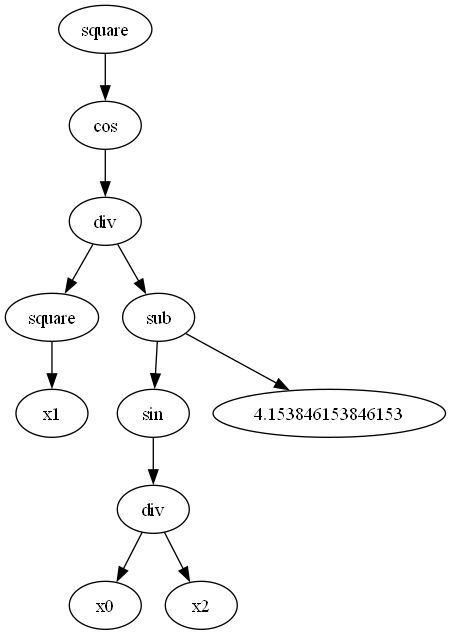

In [117]:
# create a tree
tree = create_tree(10, '../data/problem_2.npz')
print(tree)
print(type(tree))
draw_tree(tree)

Population class

In [118]:
class Population:
    def __init__(self, size, num_nodes, file_name, individuals=None):
        """
        Initialize a population of random individuals (trees).
        
        :param size: Number of individuals in the population.
        :param num_nodes: Number of nodes for each tree.
        :param file_name: the .npz file containing the data
        """
        # self.individuals = [
        #     create_tree(num_nodes, x_data) for _ in range(size)
        # ]
        
        # Assuming x_data is loaded from 'problem_20.npz', let's load it properly
        data = np.load(file_name)
        x_data = data['x']  # Assuming 'x' is the key for your data in the .npz file
        y_data = data['y']  # Assuming 'y' is the key for your labels (if you need it)

        # Make sure x_data is a NumPy array
        x_data = np.array(x_data)
        
        self.size = size
        
        if individuals:
            self.individuals = individuals
        else:
            self.individuals = []
            unique_individuals = set()
            
            while len(self.individuals) < size:
                individual = create_tree(num_nodes, file_name)
                fitness_value = individual.fitness(file_name)
                
                # Check individual is valid
                if np.isnan(fitness_value) or np.isinf(fitness_value):
                    continue
                
                tree_representation = str(individual)
                
                if tree_representation not in unique_individuals and individual.tree_size() == num_nodes:
                    self.individuals.append(individual) 
                    unique_individuals.add(tree_representation)
                

    def evaluate_fitness(self, file_path, complexity_penalty=0.01):
        """
        Evaluate the fitness of all individuals in the population.
        
        :param file_path: Path to the .npz file containing 'x' and 'y'.
        :param complexity_penalty: Penalty for tree complexity.
        """
        for individual in self.individuals:
            individual.fitness_value = individual.fitness(file_path)
        
    def get_best_individual(self):
        """
        Get the individual with the best fitness in the population.
        
        :return: The best individual.
        """
        return min(self.individuals, key=lambda ind: ind.fitness_value)
    
    def get_worst_individual(self):
        """
        Get the individual with the best fitness in the population.
        
        :return: The best individual.
        """
        return max(self.individuals, key=lambda ind: ind.fitness_value)

    def get_average_fitness(self):
        """
        Get the average fitness of the population.
        
        :return: Average fitness value.
        """
        return np.mean([ind.fitness_value for ind in self.individuals])
    
    def tournament_selection(self, tournament_size=3):
        """
        Perform probabilistic tournament selection to choose an individual from the population.
        
        :param tournament_size: Number of individuals in the tournament.
        :return: The selected individual.
        """
        # Randomly select individuals for the tournament
        tournament = random.sample(self.individuals, tournament_size)
        
        # Individual with best fitness
        winner = min(tournament, key=lambda ind: ind.fitness_value)

        return winner
    
    def tournament_selection2(self, tournament_size=3, selection_probability=0.8):
        """
        Perform probabilistic tournament selection to choose an individual from the population.
        probability will roughly be p, p(1-p), p(1−p)^2,...for the first, second, third fittest, and so on
        
        :param tournament_size: Number of individuals in the tournament.
        :param selection_probability: Probability of selecting the fittest individual in the tournament.
        :return: The selected individual.
        """
        # Randomly select individuals for the tournament
        tournament = random.sample(self.individuals, tournament_size)
        
        # Sort the tournament individuals by fitness (ascending order for minimization problems)
        sorted_tournament = sorted(tournament, key=lambda ind: ind.fitness_value)
        for individual in sorted_tournament:
            print(individual.fitness_value)
        
        
        while len(sorted_tournament) > 1:
            # Select the fittest individual (first in sorted list)
            fittest_individual = sorted_tournament[0]
            
            # Decide whether to select this individual
            if random.random() < selection_probability:
                return fittest_individual
            
            # If not selected, remove the fittest individual and continue
            sorted_tournament.pop(0)
    
        # If only one individual is left, return it
        return sorted_tournament[0]

In [179]:
populazione = Population(10, 7, '../data/problem_1.npz')
for individual in populazione.individuals:
    print(individual.fitness_value)
selected = populazione.tournament_selection2()
print(selected.fitness_value)

C:\Users\reem_\AppData\Local\Temp\ipykernel_24620\264050312.py:31: RuntimeWarning: overflow encountered in exp
  return UNARY_OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_24620\264050312.py:31: RuntimeWarning: invalid value encountered in sin
  return UNARY_OPERATORS[self.value](left_value)


No variable included in the tree; retrying...
6449784.215458696
2.673961220608003
7.7792548062529425
0.7356952362147973
0.9596261261055077
0.010424282420171417
1.3115168234625572
0.8794210714879419
48.16768643308347
0.27669324767365494
2.673961220608003
7.7792548062529425
6449784.215458696
2.673961220608003


In [181]:
def get_random_node(tree):
    """
    Select a random node from the tree.
    
    :return: A randomly selected node from the tree.
    """
    all_nodes = tree.get_all_nodes()
    return random.choice(all_nodes) if all_nodes else None

def rebuild_subtree(node):
    """
    Rebuild a subtree starting from the given node, replicating it exactly.
    
    :param node: The root node of the subtree to replicate.
    :return: A new Node that is a copy of the subtree rooted at `node`.
    """
    if node is None:
        return None

    # Create a copy of the current node
    new_node = Node(value=node.value, is_operator=node.is_operator)

    # Recursively copy the left and right children
    new_node.left = rebuild_subtree(node.left)
    new_node.right = rebuild_subtree(node.right)

    return new_node

def extract_and_rebuild_subtree(tree):
    """
    Extract and rebuild a random subtree from the tree.

    :return: A new subtree that is a copy of the randomly chosen subtree.
    """
    random_node = get_random_node(tree)
    if random_node is None:
        raise ValueError("Tree is empty; cannot extract a subtree.")

    # Rebuild the subtree starting from the selected node
    subtree = Individual(rebuild_subtree(tree, random_node))
    return subtree


def replace_subtree(tree, target_node, new_subtree):
    """
    Replace a subtree in the tree with a new subtree.
    
    :param tree: The tree (Individual) to modify.
    :param target_node: The node where the replacement should happen.
    :param new_subtree: The new subtree to replace the old one.
    :return: The modified tree (Individual).
    """
    # Find the parent node of the target node
    parent_node = None
    stack = [tree.root]
    while stack:
        current_node = stack.pop()
        if current_node.left == target_node or current_node.right == target_node:
            parent_node = current_node
            break
        if current_node.left:
            stack.append(current_node.left)
        if current_node.right:
            stack.append(current_node.right)

    # Replace the target node with the new subtree
    if parent_node:
        if parent_node.left == target_node:
            parent_node.left = new_subtree
        else:
            parent_node.right = new_subtree
    else:
        # If the target node is the root, replace the entire tree
        tree.root = new_subtree
    return tree


def subtree_crossover(tree1, tree2):
    """
    Perform subtree crossover between two trees.
    
    :param tree1: The first tree (Individual) to crossover.
    :param tree2: The second tree (Individual) to crossover.
    :param x_data: The x_data to use for generating new subtrees.
    :return: Two new trees resulting from the crossover operation.
    """        
    node1 = get_random_node(tree1)
    node2 = get_random_node(tree2)
    
    if node1 is None or node2 is None:
        raise ValueError("One or both trees are empty; cannot perform crossover.")
    
    # Extract subtrees from each tree
    subtree1 = rebuild_subtree(node1)
    subtree2 = rebuild_subtree(node2)
    
    # Replace subtrees in the opposite trees
    new_tree1 = replace_subtree(tree1, node1, subtree2)
    new_tree2 = replace_subtree(tree2, node2, subtree1)
    
    return new_tree1, new_tree2

In [219]:
def new_subtree_mutation(tree, file_name):
    """
    Perform subtree mutation on a given tree.
    
    :param tree: The tree to mutate.
    :param file_name: The .npz file containing the data.
    """
    # Get a random node from the tree
    target_node = get_random_node(tree)
    
    if target_node is None:
        raise ValueError("Tree is empty; cannot perform mutation.")

    # Calculate the size of the subtree rooted at the selected node
    subtree_individual = Individual(target_node, file_name)
    subtree_size = subtree_individual.tree_size()

    # Create a new subtree with the same size
    new_subtree = create_tree(subtree_size, file_name).root

    # Replace the selected subtree with the new one
    replace_subtree(tree, target_node, new_subtree)
    
    return tree

def constant_mutation(tree, file_name):
    """"
    Perform constant mutation on a given tree by multiplying a constant by another one.
    
    :param tree: The tree to mutate.
    """
    # Get a random node from the tree
    target_node = get_random_node(tree)
    
    if target_node is None:
        raise ValueError("Tree is empty; cannot perform mutation.")
    
    # If the target node is a constant node, replace it with a new constant
    if target_node.value in CONSTANTS:
        target_node.value *= random.choice(CONSTANTS) 
    
    return tree

def operator_mutation(tree, file_name):
    """"
    Perform operator mutation on a given tree by replacing an operator with another one of the same degree.
    
    :param tree: The tree to mutate.
    """
    # Get a random node from the tree
    target_node = get_random_node(tree)
    print(target_node.value)
    if target_node is None:
        raise ValueError("Tree is empty; cannot perform mutation.")
    
    while target_node.is_operator == False:
        target_node = get_random_node(tree)
        
    # If the target node is an operator node, replace it with a new operator of the same degree
    if target_node.is_operator:
        new_value = target_node.value
        if target_node.value in list(UNARY_OPERATORS.keys()):
            while new_value == target_node.value:
                new_value = random.choice(list(UNARY_OPERATORS.keys())) 
        elif target_node.value in list(BINARY_OPERATORS.keys()):
            while new_value == target_node.value:
                new_value = random.choice(list(BINARY_OPERATORS.keys()))
                
        target_node.value = new_value
    
    return tree


def append_mutation(tree, file_name):
    """
    Append a node to a leaf of the tree.
    
    :param tree: The root node of the tree.
    :param file_name: The file name for generating new nodes.
    """
    # Generate a random leaf node
    data = np.load(file_name)
    x_data = data['x']
    variables = [f'x{i}' for i in range(x_data.shape[0])]
    
    leaf_nodes = [node for node in tree.get_all_nodes() if node.left is None and node.right is None]
    if leaf_nodes:
        random_leaf = random.choice(leaf_nodes)
        
    if random.random() < 0.5:
        # Binary operator case
        new_operator = Node(random.choice(list(BINARY_OPERATORS.keys())), is_operator=True)
        new_node = Node(random.choice(CONSTANTS + variables), is_operator=False)
        
        if random.random() < 0.5:
            new_operator.left = random_leaf
            new_operator.right = new_node
            new_tree = Individual(new_operator, file_name) 
            mutated_tree = replace_subtree(tree, random_leaf, new_tree.root)
        else:
            new_operator.left = new_node
            new_operator.right = random_leaf
            new_tree = Individual(new_operator, file_name)
            mutated_tree = replace_subtree(tree, random_leaf, new_tree.root)
    else:
        new_operator = Node(random.choice(list(UNARY_OPERATORS.keys())), is_operator=True)
        new_operator.left = random_leaf
        new_operator.right = None
        new_tree = Individual(new_operator, file_name)
        draw_tree(new_tree)
        mutated_tree = replace_subtree(tree, random_leaf, new_tree.root)

    return mutated_tree

def prepend_mutation(tree, file_name):
    """
    Prepend a node to the root of the tree.
    
    :param tree: The root node of the tree.
    :param file_name: The file name for generating new nodes.
    """
    if random.random() < 0.5:
        # Binary operator case
        new_root = Node(random.choice(list(BINARY_OPERATORS.keys())), is_operator=True)
        
        # Generate a random leaf node
        data = np.load(file_name)
        x_data = data['x']
        variables = [f'x{i}' for i in range(x_data.shape[0])]

        new_node = Node(random.choice(CONSTANTS + variables), is_operator=False)
        
        if random.random() < 0.5:
            new_root.left = Node('x0', is_operator=False)
            new_root.right = new_node
            new_tree = Individual(new_root, file_name) 
            mutated_tree = replace_subtree(new_tree, new_root.left, tree.root)
        else:
            new_root.left = new_node
            new_root.right = Node('x0', is_operator=False)
            new_tree = Individual(new_root, file_name)
            mutated_tree = replace_subtree(new_tree, new_root.right, tree.root)
    else:
        new_root = Node(random.choice(list(UNARY_OPERATORS.keys())), is_operator=True)
        new_root.left = Node('x0', is_operator=False)
        new_root.right = None
        new_tree = Individual(new_root, file_name)
        mutated_tree = replace_subtree(new_tree, new_root.left, tree.root)

    return mutated_tree

def delete_subtree_mutation(tree, file_name):
    """
    Delete a random subtree from the tree.
    
    :param tree: The root node of the tree.
    """
    data = np.load(file_name)
    x_data = data['x']
    variables = [f'x{i}' for i in range(x_data.shape[0])]
    # Get a random node from the tree
    target_node = get_random_node(tree)
    new_node = Node(random.choice(CONSTANTS + variables), is_operator=False)
    
    if target_node is None:
        raise ValueError("Tree is empty; cannot perform mutation.")
    
    # Replace the selected subtree with None
    replace_subtree(tree, target_node, new_node)
    
    return tree


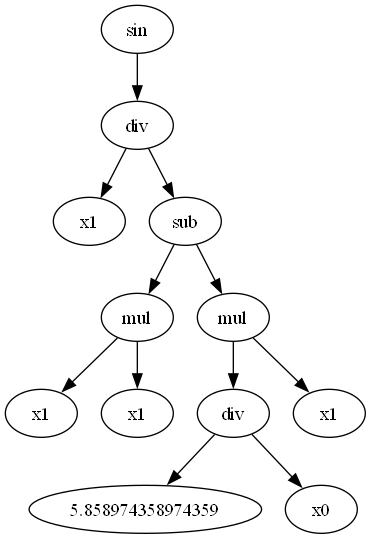

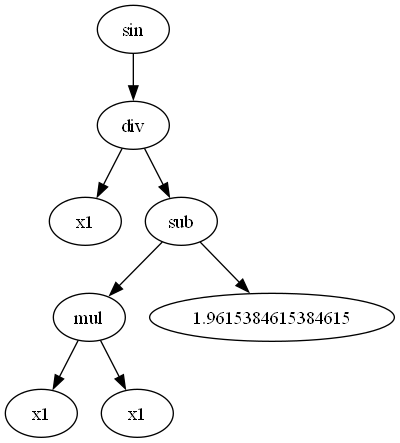

In [232]:
#Assuming x_data is loaded from 'problem_20.npz', let's load it properly
data = np.load('../data/problem_0.npz')
x_data = data['x']  # Assuming 'x' is the key for your data in the .npz file
y_data = data['y']  # Assuming 'y' is the key for your labels (if you need it)

# Make sure x_data is a NumPy array
x_data = np.array(x_data)

# Create a random tree
random_tree = create_tree(10, '../data/problem_0.npz')
draw_tree(random_tree)


#Perform subtree mutation
mutated = delete_subtree_mutation(random_tree, '../data/problem_0.npz') 

draw_tree(mutated)

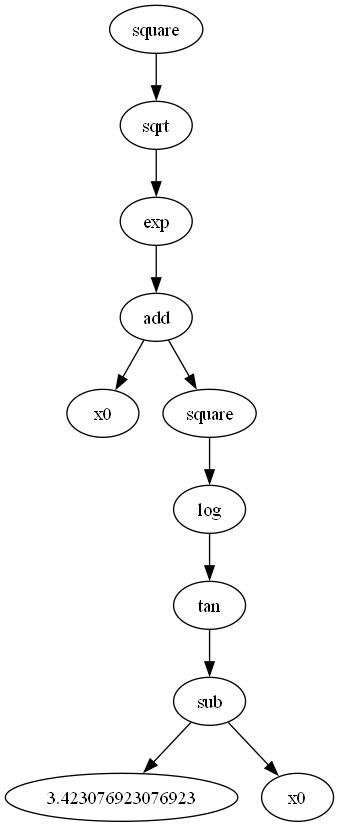

square(sqrt(exp((add(x0, square(log(tan((sub(3.423076923076923, x0))))))))
No variable included in the tree; retrying...


C:\Users\reem_\AppData\Local\Temp\ipykernel_24620\264050312.py:39: RuntimeWarning: overflow encountered in power
  return BINARY_OPERATORS[self.value](left_value, right_value)


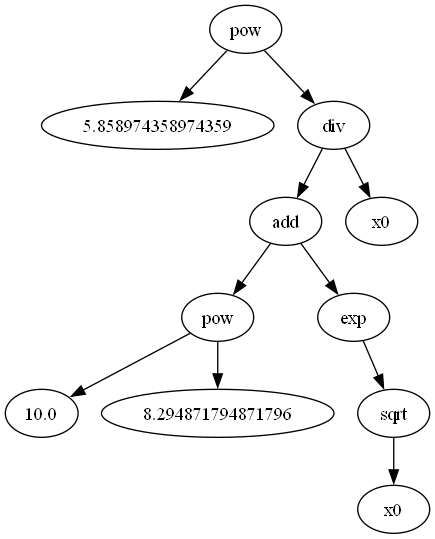

(pow(5.858974358974359, (div((add((pow(10.0, 8.294871794871796), exp(sqrt(x0))), x0))


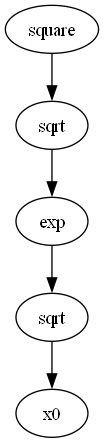

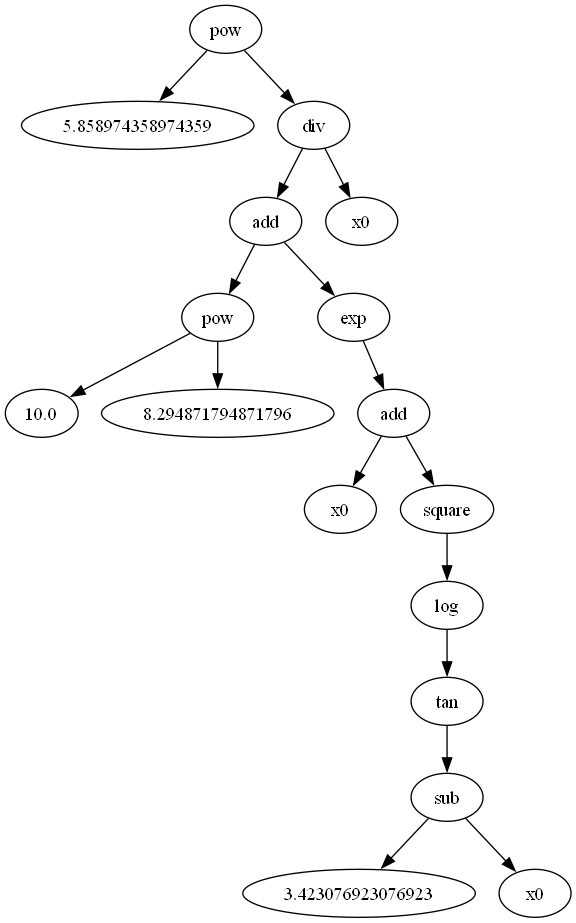

square(sqrt(exp(sqrt(x0))))
(pow(5.858974358974359, (div((add((pow(10.0, 8.294871794871796), exp((add(x0, square(log(tan((sub(3.423076923076923, x0))))))), x0))


In [146]:
#Assuming x_data is loaded from 'problem_20.npz', let's load it properly
data = np.load('../data/problem_0.npz')

file_name = '../data/problem_0.npz'
x_data = data['x']  # Assuming 'x' is the key for your data in the .npz file
y_data = data['y']  # Assuming 'y' is the key for your labels (if you need it)

# Make sure x_data is a NumPy array
x_data = np.array(x_data)

# Create a random tree
random_tree1 = create_tree(10, file_name)
draw_tree(random_tree1)
print(random_tree1)
random_tree2 = create_tree(10, file_name)
draw_tree(random_tree2)
print(random_tree2)

new_tree1, new_tree2 = subtree_crossover(random_tree1, random_tree2)
draw_tree(new_tree1)
draw_tree(new_tree2)
print(new_tree1)
print(new_tree2)

START

In [31]:
# Parameters
population_size = 50
tree_size = 10
max_tree_depth = 5
file_name = '../data/problem_0.npz'

# Assuming x_data is loaded from 'problem_20.npz', let's load it properly
data = np.load(file_name)
x_data = data['x']  # Assuming 'x' is the key for your data in the .npz file
y_data = data['y']  # Assuming 'y' is the key for your labels (if you need it)

# Make sure x_data is a NumPy array
x_data = np.array(x_data)

# Create a population
population2 = Population(size=population_size, num_nodes=tree_size, file_name='../data/problem_0.npz')

# Evaluate the population's fitness
population2.evaluate_fitness(file_name)

# Get the best individual
best_individual = population2.get_best_individual()
print("Best Fitness Value:", best_individual.fitness(file_name))
print("mse percentage", mse_percentage(best_individual.fitness(file_name), '../data/problem_0.npz'))
print("Best Individual:", best_individual)

worst_individual = population2.get_worst_individual()
print("Worst Fitness Value:", worst_individual.fitness(file_name))
print("mse percentage", mse_percentage(worst_individual.fitness(file_name), '../data/problem_0.npz'))
population2.individuals.remove(worst_individual)

C:\Users\reem_\AppData\Local\Temp\ipykernel_7652\727160885.py:39: RuntimeWarning: invalid value encountered in power
  return OPERATORS[self.value](left_value, right_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_7652\727160885.py:31: RuntimeWarning: invalid value encountered in cos
  return OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_7652\727160885.py:31: RuntimeWarning: overflow encountered in exp
  return OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_7652\2319203941.py:59: RuntimeWarning: overflow encountered in square
  mse = np.mean((y - y_pred) ** 2)
C:\Users\reem_\AppData\Local\Temp\ipykernel_7652\727160885.py:39: RuntimeWarning: invalid value encountered in subtract
  return OPERATORS[self.value](left_value, right_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_7652\727160885.py:39: RuntimeWarning: invalid value encountered in add
  return OPERATORS[self.value](left_value, right_value)
C:\Users\reem_\AppDa

Best Fitness Value: 2.0271574567438084
mse percentage 31.46718394581037
Best Individual: sin((div((add(square(x0), square(sin(square(x1)))), x0))
Worst Fitness Value: 5.6698383562350896e+22
mse percentage 8.801183445574278e+23


In [234]:
def create_generation(current_population, file_name, crossover_rate=0.8, elite_size = 3):
    """
    Create a new generation of individuals using mutation and crossover.

    :param current_population: The current population of individuals.
    :param file_name: The file name for fitness calculations.
    :param crossover_rate: The probability of performing crossover.
    :param elite_size: The number of top individuals to retain.
    :return: A new Population object representing the next generation.
    """
    # Sort population by fitness and copy elites
    sorted_population = sorted(current_population.individuals, key=lambda ind: ind.fitness(file_name))
    new_generation = []
    
    for i in range(elite_size):
        elite = sorted_population[i]
        elite_copy = Individual(rebuild_subtree(elite, elite.root), file_name)
        new_generation.append(elite_copy)
        
    # Create the rest of the new generation
    while len(new_generation) < len(current_population.individuals):        
        # Perform crossover with probability `crossover_rate`
        if random.random() < crossover_rate:
            # Perform tournament selection to choose parents
            parent1 = current_population.tournament_selection()
            parent2 = current_population.tournament_selection()
            while (parent1 == parent2):
                parent2 = current_population.tournament_selection()
            
            try:    
                child1, child2 = subtree_crossover(parent1, parent2)
                if not np.isnan(child1.fitness(file_name)) and not np.isinf(child1.fitness(file_name)):
                    child1_copy = Individual(rebuild_subtree(child1, child1.root), file_name)
                    if len(new_generation) < len(current_population.individuals):
                        new_generation.append(child1_copy)
                if not np.isnan(child2.fitness(file_name)) and not np.isinf(child2.fitness(file_name)):
                    child2_copy = Individual(rebuild_subtree(child2, child2.root), file_name)
                    if len(new_generation) < len(current_population.individuals):
                        new_generation.append(child2_copy)
            except:
                continue        
        else:
            # Perform mutation
            selected_individual = current_population.tournament_selection()
            try:
                mutated = subtree_mutation(selected_individual, file_name)
                if not np.isnan(mutated.fitness(file_name)) and not np.isinf(mutated.fitness(file_name)):
                    mutated_copy = Individual(rebuild_subtree(mutated, mutated.root), file_name)
                    if len(new_generation) < len(current_population.individuals):
                        new_generation.append(mutated_copy)                       
            except:
                continue
    
    new_generation = new_generation[:len(current_population.individuals)]
    new_population = Population(size=0, num_nodes=tree_size, file_name=file_name, individuals=new_generation)

    # Verify that the best fitness is preserved
    new_best = min(ind.fitness(file_name) for ind in new_population.individuals)
    old_best = min(ind.fitness(file_name) for ind in current_population.individuals)
    assert new_best <= old_best, f"Best fitness got worse from {old_best} to {new_best}"
    
    return new_population

In [ ]:
#parameters
file_name = '../data/problem_1.npz'
population_size = 100
elite_size = 3
tree_size = 10
num_generations = 100

current_population = Population(size=population_size, num_nodes=tree_size, file_name=file_name)

best_individual = current_population.get_best_individual()
print("Initial Best Individual:", best_individual)
print("Initial Best MSE Value:", best_individual.fitness(file_name))
print("Initial MSE percentage", mse_percentage(best_individual.fitness(file_name), file_name))

for generation in range(num_generations):
    new_population = create_generation(current_population, file_name, elite_size=elite_size)
            
    # for ind in new_population.individuals:
    #     print(str(ind) + ":" + str(ind.fitness_value))
    
    new_best_individual = new_population.get_best_individual()
    print(f"Generation {generation+1}")
    print("Best Individual:", new_best_individual)
    print("Best MSE Value:", new_best_individual.fitness(file_name))
    current_population.individuals = new_population.individuals[:]
            
print("MSE percentage", mse_percentage(new_population.get_best_individual().fitness_value, file_name))

C:\Users\reem_\AppData\Local\Temp\ipykernel_24620\264050312.py:39: RuntimeWarning: invalid value encountered in power
  return BINARY_OPERATORS[self.value](left_value, right_value)


No variable included in the tree; retrying...


C:\Users\reem_\AppData\Local\Temp\ipykernel_24620\264050312.py:31: RuntimeWarning: invalid value encountered in tan
  return UNARY_OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_24620\264050312.py:31: RuntimeWarning: overflow encountered in exp
  return UNARY_OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_24620\264050312.py:31: RuntimeWarning: invalid value encountered in cos
  return UNARY_OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_24620\264050312.py:31: RuntimeWarning: invalid value encountered in sin
  return UNARY_OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_24620\264050312.py:39: RuntimeWarning: divide by zero encountered in power
  return BINARY_OPERATORS[self.value](left_value, right_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_24620\2319203941.py:59: RuntimeWarning: overflow encountered in square
  mse = np.mean((y - y_pred) ** 2)


No variable included in the tree; retrying...
No variable included in the tree; retrying...


C:\Users\reem_\AppData\Local\Temp\ipykernel_24620\2566688939.py:11: RuntimeWarning: overflow encountered in divide
  return np.divide(a, b, where=b != 0, out=np.full_like(a, np.nan)) # Safe divide for b != 0, else nan. With NaN, you'll know exactly where and why a result is invalid. With 0, you'll have valid numbers for calculations, but the invalid results may not be easy to track.


No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
Initial Best Individual: (sub(x0, square(exp(log(log(sin((mul(x0, x0)))))))
Initial Best MSE Value: 0.003281545223894703
Initial MSE percentage 0.1963579503299693


C:\Users\reem_\AppData\Local\Temp\ipykernel_24620\264050312.py:39: RuntimeWarning: overflow encountered in power
  return BINARY_OPERATORS[self.value](left_value, right_value)


NameError: name 'create_generation' is not defined

pysr

In [238]:
from pysr import PySRRegressor
import numpy as np
import pandas as pd

data = np.load('../data/problem_1.npz')
x_train = data['x']
y_train = data['y']

# Generate some data (for demonstration)
np.random.seed(42)

x = x_train
x = x.T
print(x.shape)
y = y_train.reshape(-1,1)  # y = x^2 + sin(x) + noise



# Define the symbolic regressor
model = PySRRegressor(
    niterations=10,  # Number of iterations for evolution (previously generations)
    population_size=20,  # Number of candidate equations in each iteration
    parallelism='multiprocessing',  # Use all CPU cores for parallelization (instead of n_jobs)
    verbosity=True,  # Show progress
    unary_operators=['exp', 'log', 'sqrt', 'square', 'sin', 'cos', 'tan'],  # Unary operators to consider
    binary_operators=['+', '-', '*', '/', 'pow'],  # Binary operators to consider
)

# Fit the model to the data
model.fit(x,y)

# Get the best symbolic expression discovered
#print("Best symbolic equation found:", model.equations_[0])


(500, 1)


c:\Users\reem_\OneDrive\Desktop\polito\sem9\ComputationalIntelligence\github\VENV\Lib\site-packages\pysr\sr.py:2766: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
c:\Users\reem_\OneDrive\Desktop\polito\sem9\ComputationalIntelligence\github\VENV\Lib\site-packages\pysr\sr.py:84: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Automatically setting `--heap-size-hint=483M` on each Julia process. You can configure this with the `heap_size_hint_in_bytes` parameter.
[ Info: Importing SymbolicRegression on workers.
[ Info: Finished!
[ Info: Testing module on workers...
[ Info: Finished!
[ 

───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.535e-01  1.594e+01  y = -0.02858
2           3.741e-16  1.594e+01  y = sin(x₀)
24          3.741e-16  8.399e-07  y = (-1.8539e-08 / tan(exp(sin(cos(tan(0.726 * sin(cos(1.1...
                                      611 / (x₀ * (1.1106 ^ 0.10488)))))) * tan(0.47282))))) + s...
                                      in(x₀)
30          3.741e-16  1.466e-05  y = (-1.8539e-08 / tan(exp(sin(cos(tan(0.726 * sin(cos(((-...
                                      8.8384e-07 / x₀) + 1.1611) / (x₀ * cos(1.1106 ^ square(1.0...
                                      622))))))) * tan(0.47282))))) + sin(x₀)
───────────────────────────────────────────────────────────────────────────────────────────────────


PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                       -0.028580397   
	1  >>>>  3.414975e+01                                            sin(x0)   
	2        8.468809e-07  (-1.8538913e-8 / tan(exp(sin(cos(tan(0.7259965...   
	3        1.468046e-05  (-1.8538913e-8 / tan(exp(sin(cos(tan(0.7259965...   
	
	           loss  complexity  
	0  2.535372e-01           1  
	1  3.741035e-16           2  
	2  3.740966e-16          24  
	3  3.740636e-16          30  
]

  - outputs\20250121_012015_WJ5kmt\hall_of_fame.csv
